In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
print(tf.__version__)

2.12.0


In [29]:
!wget https://github.com/mohammadsanaee/LSTM_spot_price/raw/main/df_daily.csv
df = pd.read_csv('df_daily.csv')

--2023-05-23 05:34:47--  https://github.com/mohammadsanaee/LSTM_spot_price/raw/main/df_daily.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mohammadsanaee/LSTM_spot_price/main/df_daily.csv [following]
--2023-05-23 05:34:47--  https://raw.githubusercontent.com/mohammadsanaee/LSTM_spot_price/main/df_daily.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 718637 (702K) [text/plain]
Saving to: ‘df_daily.csv.1’

df_daily.csv.1      100%[===================>] 701.79K  --.-KB/s    in 0.04s   

2023-05-23 05:34:47 (15.9 MB/s) - ‘df_daily.csv.1’ saved [718637/718637]



In [30]:
df.head()

,date,price_pesos,exchange,price_usd,gas_price,coal_price,gas_rate,coal_rate,log_price
0,2006-06-26,3696.799565,53.4002,69.228197,7.1,2.100882,9.750450,32.951961,3.426412
1,2006-06-27,4494.720000,53.4750,84.052735,7.1,2.100882,11.838413,40.008299,NaN
2,2006-06-28,3419.524583,53.5800,63.820914,7.1,2.100882,8.988861,30.378146,3.471716
3,2006-06-29,2904.085417,53.5502,54.231084,7.1,2.100882,7.638181,25.813478,3.346610
4,2006-06-30,4178.192500,53.1102,78.670246,7.1,2.100882,11.080316,37.446286,3.480780


In [31]:
df=df.loc[(df['date'] >= '2015-01-01')]


In [32]:
df1=df.reset_index()['price_pesos']

In [33]:
df1

0       2082.394527
1       2018.771891
2       1512.324746
3       2109.936419
4       4703.001446
           ...     
2263    3346.681250
2264    3571.285000
2265    2314.728333
2266    2299.245000
2267    1922.081304
Name: price_pesos, Length: 2268, dtype: float64

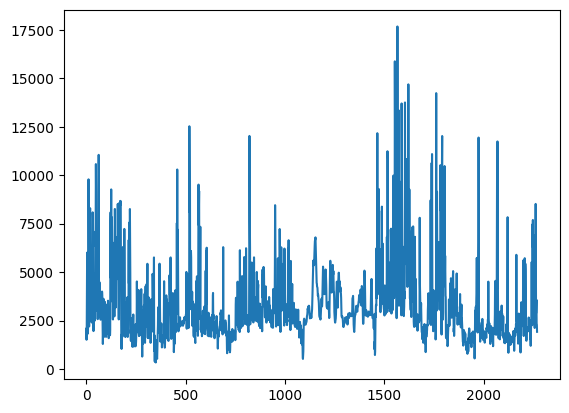

In [34]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [35]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_df=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [36]:
training_size=int(len(scaled_df)*0.85)
test_size=len(scaled_df)-training_size
train_data,test_data=scaled_df[0:training_size,:],scaled_df[training_size:len(scaled_df),:1]

In [37]:
training_size,test_size

(1927, 341)

In [38]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [39]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [40]:
y_train


array([0.07613672, 0.15013488, 0.11982514, ..., 0.08018151, 0.08742913,
       0.09286914])

In [41]:
print(X_train.shape), print(y_train.shape)

(1826, 100)
(1826,)


(None, None)

In [42]:
print(X_test.shape), print(ytest.shape)

(240, 100)
(240,)


(None, None)

In [43]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [44]:
print(X_train.shape), print(X_test.shape)

(1826, 100, 1)
(240, 100, 1)


(None, None)

In [45]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [46]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [48]:
history  = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

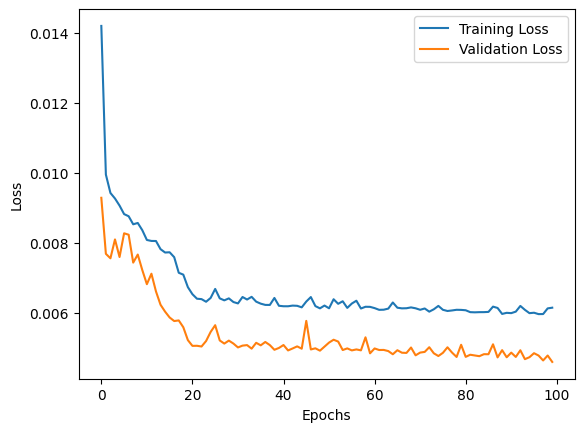

In [49]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
loss = model.evaluate(X_test, ytest)

print("Test Loss:", loss)

8/8 [==============================] - 0s 7ms/step - loss: 0.0046
Test Loss: 0.004603350069373846


In [ ]:
# ytest

In [52]:
y_true = scaler.inverse_transform(ytest.reshape(-1, 1))


In [ ]:
# y_true

In [59]:
from sklearn.metrics import mean_absolute_error

scaled_y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(scaled_y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(mae)

8/8 [==============================] - 0s 10ms/step
681.2178821138565


In [57]:
train_predict=model.predict(X_train)

58/58 [==============================] - 0s 7ms/step


In [ ]:
train_predict=scaler.inverse_transform(train_predict)
# test_predict=scaler.inverse_transform(test_predict)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: ignored

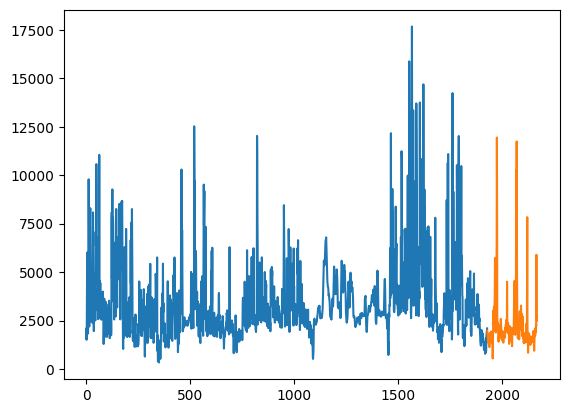

In [73]:
import matplotlib.pyplot as plt

# Plotting train data
plt.plot(scaler.inverse_transform(train_data), label='Train Data')

# Plotting test data
test_start_index = training_size 
test_end_index = test_start_index + len(ytest)
test_indices = range(test_start_index, test_end_index)
test_data_unscaled = scaler.inverse_transform(test_data[:len(ytest)])
plt.plot(test_indices, test_data_unscaled, label='Test Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


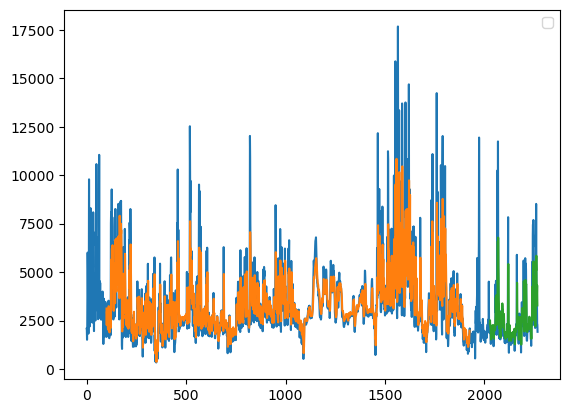

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

In [ ]:
np.sum(np.isnan(test_predict))

0

In [ ]:
len(test_data)

341

In [ ]:
x_input=test_data[241:].reshape(1,-1)
x_input.shape


(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.10338502569774691,
 0.10197402943804731,
 0.09733511704387939,
 0.07537546871985419,
 0.05599740612904784,
 0.09439387155422112,
 0.10183061577953847,
 0.14555779717775846,
 0.08117507139627127,
 0.05790215757396894,
 0.08880632473002517,
 0.08513177086304256,
 0.10002688466652832,
 0.14175557681548237,
 0.0975072929586056,
 0.06354706737040569,
 0.029773736489574546,
 0.07371794371563843,
 0.08690214853303674,
 0.11283980097623574,
 0.17932718432055456,
 0.12779224326432867,
 0.14206963302729864,
 0.12292100537553717,
 0.11907869835896571,
 0.10816281623285402,
 0.11592572789430274,
 0.11602299875010645,
 0.11340303409975487,
 0.3034863498585806,
 0.13927056495691587,
 0.09047659397660503,
 0.07881799055201275,
 0.10041286600311809,
 0.11352026411756531,
 0.10384533687742428,
 0.1487568179981357,
 0.3103732226382172,
 0.11418223497505976,
 0.13147059658624752,
 0.29408479099638196,
 0.277678071260678,
 0.18611837335847473,
 0.14308326989104125,
 0.07732417953531862,
 0.065075915132

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<300):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.13927056 0.09047659 0.07881799 0.10041287 0.11352026 0.10384534
 0.14875682 0.31037322 0.11418223 0.1314706  0.29408479 0.27767807
 0.18611837 0.14308327 0.07732418 0.06507592 0.06468254 0.0746387
 0.10257462 0.09445744 0.10483978 0.10425323 0.10531407 0.092643
 0.10269795 0.10187484 0.10160828 0.13386844 0.10703462 0.09595298
 0.09782438 0.10304849 0.10002943 0.10121996 0.08529219 0.06978322
 0.06954759 0.04958965 0.0925617  0.11292498 0.12636391 0.12018691
 0.29893867 0.11792936 0.11076924 0.38004383 0.41104079 0.34421232
 0.42408014 0.26347167 0.1234845  0.15523542 0.24264972 0.11952684
 0.11735877 0.11437355 0.1077606  0.10271827 0.10545643 0.12430992
 0.37845337 0.34686256 0.47188646 0.30553827 0.14646743 0.17346931
 0.18643192 0.11391197 0.11301838 0.09125104 0.11042573 0.11779785
 0.12025391 0.12077567 0.12167756 0.12465662 0.13032952 0.13842693
 0.14811866 0.15834993 0.16812603 0.17669845 0.18363489 0.18879297
 0.19224186 0.19417565 0.19484763 0.19453137 0.193502

8 day output [[0.1858146]]
9 day input [0.1314706  0.29408479 0.27767807 0.18611837 0.14308327 0.07732418
 0.06507592 0.06468254 0.0746387  0.10257462 0.09445744 0.10483978
 0.10425323 0.10531407 0.092643   0.10269795 0.10187484 0.10160828
 0.13386844 0.10703462 0.09595298 0.09782438 0.10304849 0.10002943
 0.10121996 0.08529219 0.06978322 0.06954759 0.04958965 0.0925617
 0.11292498 0.12636391 0.12018691 0.29893867 0.11792936 0.11076924
 0.38004383 0.41104079 0.34421232 0.42408014 0.26347167 0.1234845
 0.15523542 0.24264972 0.11952684 0.11735877 0.11437355 0.1077606
 0.10271827 0.10545643 0.12430992 0.37845337 0.34686256 0.47188646
 0.30553827 0.14646743 0.17346931 0.18643192 0.11391197 0.11301838
 0.09125104 0.11042573 0.11779785 0.12025391 0.12077567 0.12167756
 0.12465662 0.13032952 0.13842693 0.14811866 0.15834993 0.16812603
 0.17669845 0.18363489 0.18879297 0.19224186 0.19417565 0.19484763
 0.19453137 0.19350281 0.19202948 0.19035861 0.18870193 0.18722051
 0.1860161  0.18513155 0.1

20 day output [[0.19049771]]
21 day input [0.10425323 0.10531407 0.092643   0.10269795 0.10187484 0.10160828
 0.13386844 0.10703462 0.09595298 0.09782438 0.10304849 0.10002943
 0.10121996 0.08529219 0.06978322 0.06954759 0.04958965 0.0925617
 0.11292498 0.12636391 0.12018691 0.29893867 0.11792936 0.11076924
 0.38004383 0.41104079 0.34421232 0.42408014 0.26347167 0.1234845
 0.15523542 0.24264972 0.11952684 0.11735877 0.11437355 0.1077606
 0.10271827 0.10545643 0.12430992 0.37845337 0.34686256 0.47188646
 0.30553827 0.14646743 0.17346931 0.18643192 0.11391197 0.11301838
 0.09125104 0.11042573 0.11779785 0.12025391 0.12077567 0.12167756
 0.12465662 0.13032952 0.13842693 0.14811866 0.15834993 0.16812603
 0.17669845 0.18363489 0.18879297 0.19224186 0.19417565 0.19484763
 0.19453137 0.19350281 0.19202948 0.19035861 0.18870193 0.18722051
 0.1860161  0.18513155 0.18456031 0.18426204 0.18417935 0.18425153
 0.18442334 0.18464895 0.184892   0.18512504 0.18532877 0.18549185
 0.18561184 0.1856951  

31 day output [[0.19374941]]
32 day input [0.10002943 0.10121996 0.08529219 0.06978322 0.06954759 0.04958965
 0.0925617  0.11292498 0.12636391 0.12018691 0.29893867 0.11792936
 0.11076924 0.38004383 0.41104079 0.34421232 0.42408014 0.26347167
 0.1234845  0.15523542 0.24264972 0.11952684 0.11735877 0.11437355
 0.1077606  0.10271827 0.10545643 0.12430992 0.37845337 0.34686256
 0.47188646 0.30553827 0.14646743 0.17346931 0.18643192 0.11391197
 0.11301838 0.09125104 0.11042573 0.11779785 0.12025391 0.12077567
 0.12167756 0.12465662 0.13032952 0.13842693 0.14811866 0.15834993
 0.16812603 0.17669845 0.18363489 0.18879297 0.19224186 0.19417565
 0.19484763 0.19453137 0.19350281 0.19202948 0.19035861 0.18870193
 0.18722051 0.1860161  0.18513155 0.18456031 0.18426204 0.18417935
 0.18425153 0.18442334 0.18464895 0.184892   0.18512504 0.18532877
 0.18549185 0.18561184 0.1856951  0.18575592 0.1858146  0.185894
 0.18601637 0.18619992 0.18645674 0.18679139 0.18720137 0.18767762
 0.18820642 0.18877085

43 day output [[0.1952851]]
44 day input [0.11076924 0.38004383 0.41104079 0.34421232 0.42408014 0.26347167
 0.1234845  0.15523542 0.24264972 0.11952684 0.11735877 0.11437355
 0.1077606  0.10271827 0.10545643 0.12430992 0.37845337 0.34686256
 0.47188646 0.30553827 0.14646743 0.17346931 0.18643192 0.11391197
 0.11301838 0.09125104 0.11042573 0.11779785 0.12025391 0.12077567
 0.12167756 0.12465662 0.13032952 0.13842693 0.14811866 0.15834993
 0.16812603 0.17669845 0.18363489 0.18879297 0.19224186 0.19417565
 0.19484763 0.19453137 0.19350281 0.19202948 0.19035861 0.18870193
 0.18722051 0.1860161  0.18513155 0.18456031 0.18426204 0.18417935
 0.18425153 0.18442334 0.18464895 0.184892   0.18512504 0.18532877
 0.18549185 0.18561184 0.1856951  0.18575592 0.1858146  0.185894
 0.18601637 0.18619992 0.18645674 0.18679139 0.18720137 0.18767762
 0.18820642 0.18877085 0.18935265 0.18993384 0.19049771 0.19103
 0.19151944 0.19195828 0.19234227 0.19267066 0.19294581 0.19317274
 0.19335827 0.19351056 0.1

55 day output [[0.19689624]]
56 day input [0.1077606  0.10271827 0.10545643 0.12430992 0.37845337 0.34686256
 0.47188646 0.30553827 0.14646743 0.17346931 0.18643192 0.11391197
 0.11301838 0.09125104 0.11042573 0.11779785 0.12025391 0.12077567
 0.12167756 0.12465662 0.13032952 0.13842693 0.14811866 0.15834993
 0.16812603 0.17669845 0.18363489 0.18879297 0.19224186 0.19417565
 0.19484763 0.19453137 0.19350281 0.19202948 0.19035861 0.18870193
 0.18722051 0.1860161  0.18513155 0.18456031 0.18426204 0.18417935
 0.18425153 0.18442334 0.18464895 0.184892   0.18512504 0.18532877
 0.18549185 0.18561184 0.1856951  0.18575592 0.1858146  0.185894
 0.18601637 0.18619992 0.18645674 0.18679139 0.18720137 0.18767762
 0.18820642 0.18877085 0.18935265 0.18993384 0.19049771 0.19103
 0.19151944 0.19195828 0.19234227 0.19267066 0.19294581 0.19317274
 0.19335827 0.19351056 0.19363815 0.19374941 0.1938519  0.19395204
 0.19405477 0.19416355 0.19428045 0.19440614 0.19454029 0.19468176
 0.19482894 0.19497983 0.

67 day output [[0.19817829]]
68 day input [0.11301838 0.09125104 0.11042573 0.11779785 0.12025391 0.12077567
 0.12167756 0.12465662 0.13032952 0.13842693 0.14811866 0.15834993
 0.16812603 0.17669845 0.18363489 0.18879297 0.19224186 0.19417565
 0.19484763 0.19453137 0.19350281 0.19202948 0.19035861 0.18870193
 0.18722051 0.1860161  0.18513155 0.18456031 0.18426204 0.18417935
 0.18425153 0.18442334 0.18464895 0.184892   0.18512504 0.18532877
 0.18549185 0.18561184 0.1856951  0.18575592 0.1858146  0.185894
 0.18601637 0.18619992 0.18645674 0.18679139 0.18720137 0.18767762
 0.18820642 0.18877085 0.18935265 0.18993384 0.19049771 0.19103
 0.19151944 0.19195828 0.19234227 0.19267066 0.19294581 0.19317274
 0.19335827 0.19351056 0.19363815 0.19374941 0.1938519  0.19395204
 0.19405477 0.19416355 0.19428045 0.19440614 0.19454029 0.19468176
 0.19482894 0.19497983 0.19513249 0.1952851  0.19543619 0.19558468
 0.1957297  0.195871   0.19600846 0.19614242 0.19627328 0.19640146
 0.19652753 0.1966518  0.

79 day output [[0.19905904]]
80 day input [0.16812603 0.17669845 0.18363489 0.18879297 0.19224186 0.19417565
 0.19484763 0.19453137 0.19350281 0.19202948 0.19035861 0.18870193
 0.18722051 0.1860161  0.18513155 0.18456031 0.18426204 0.18417935
 0.18425153 0.18442334 0.18464895 0.184892   0.18512504 0.18532877
 0.18549185 0.18561184 0.1856951  0.18575592 0.1858146  0.185894
 0.18601637 0.18619992 0.18645674 0.18679139 0.18720137 0.18767762
 0.18820642 0.18877085 0.18935265 0.18993384 0.19049771 0.19103
 0.19151944 0.19195828 0.19234227 0.19267066 0.19294581 0.19317274
 0.19335827 0.19351056 0.19363815 0.19374941 0.1938519  0.19395204
 0.19405477 0.19416355 0.19428045 0.19440614 0.19454029 0.19468176
 0.19482894 0.19497983 0.19513249 0.1952851  0.19543619 0.19558468
 0.1957297  0.195871   0.19600846 0.19614242 0.19627328 0.19640146
 0.19652753 0.1966518  0.19677468 0.19689624 0.19701651 0.19713537
 0.19725257 0.19736773 0.1974805  0.19759049 0.19769731 0.19780077
 0.19790061 0.19799678 0.

91 day output [[0.19975059]]
92 day input [0.18722051 0.1860161  0.18513155 0.18456031 0.18426204 0.18417935
 0.18425153 0.18442334 0.18464895 0.184892   0.18512504 0.18532877
 0.18549185 0.18561184 0.1856951  0.18575592 0.1858146  0.185894
 0.18601637 0.18619992 0.18645674 0.18679139 0.18720137 0.18767762
 0.18820642 0.18877085 0.18935265 0.18993384 0.19049771 0.19103
 0.19151944 0.19195828 0.19234227 0.19267066 0.19294581 0.19317274
 0.19335827 0.19351056 0.19363815 0.19374941 0.1938519  0.19395204
 0.19405477 0.19416355 0.19428045 0.19440614 0.19454029 0.19468176
 0.19482894 0.19497983 0.19513249 0.1952851  0.19543619 0.19558468
 0.1957297  0.195871   0.19600846 0.19614242 0.19627328 0.19640146
 0.19652753 0.1966518  0.19677468 0.19689624 0.19701651 0.19713537
 0.19725257 0.19736773 0.1974805  0.19759049 0.19769731 0.19780077
 0.19790061 0.19799678 0.19808933 0.19817829 0.19826388 0.19834632
 0.19842589 0.19850293 0.19857775 0.19865067 0.1987219  0.19879168
 0.19886023 0.19892757 0.

103 day output [[0.20027581]]
104 day input [0.18549185 0.18561184 0.1856951  0.18575592 0.1858146  0.185894
 0.18601637 0.18619992 0.18645674 0.18679139 0.18720137 0.18767762
 0.18820642 0.18877085 0.18935265 0.18993384 0.19049771 0.19103
 0.19151944 0.19195828 0.19234227 0.19267066 0.19294581 0.19317274
 0.19335827 0.19351056 0.19363815 0.19374941 0.1938519  0.19395204
 0.19405477 0.19416355 0.19428045 0.19440614 0.19454029 0.19468176
 0.19482894 0.19497983 0.19513249 0.1952851  0.19543619 0.19558468
 0.1957297  0.195871   0.19600846 0.19614242 0.19627328 0.19640146
 0.19652753 0.1966518  0.19677468 0.19689624 0.19701651 0.19713537
 0.19725257 0.19736773 0.1974805  0.19759049 0.19769731 0.19780077
 0.19790061 0.19799678 0.19808933 0.19817829 0.19826388 0.19834632
 0.19842589 0.19850293 0.19857775 0.19865067 0.1987219  0.19879168
 0.19886023 0.19892757 0.1989938  0.19905904 0.1991232  0.19918631
 0.19924828 0.1993091  0.19936872 0.19942708 0.19948421 0.19954005
 0.19959459 0.1996478  

115 day output [[0.20067109]]
116 day input [0.18820642 0.18877085 0.18935265 0.18993384 0.19049771 0.19103
 0.19151944 0.19195828 0.19234227 0.19267066 0.19294581 0.19317274
 0.19335827 0.19351056 0.19363815 0.19374941 0.1938519  0.19395204
 0.19405477 0.19416355 0.19428045 0.19440614 0.19454029 0.19468176
 0.19482894 0.19497983 0.19513249 0.1952851  0.19543619 0.19558468
 0.1957297  0.195871   0.19600846 0.19614242 0.19627328 0.19640146
 0.19652753 0.1966518  0.19677468 0.19689624 0.19701651 0.19713537
 0.19725257 0.19736773 0.1974805  0.19759049 0.19769731 0.19780077
 0.19790061 0.19799678 0.19808933 0.19817829 0.19826388 0.19834632
 0.19842589 0.19850293 0.19857775 0.19865067 0.1987219  0.19879168
 0.19886023 0.19892757 0.1989938  0.19905904 0.1991232  0.19918631
 0.19924828 0.1993091  0.19936872 0.19942708 0.19948421 0.19954005
 0.19959459 0.1996478  0.1996998  0.19975059 0.19980012 0.19984853
 0.1998958  0.19994198 0.19998711 0.20003128 0.20007442 0.2001166
 0.20015778 0.20019807

127 day output [[0.20096983]]
128 day input [0.19335827 0.19351056 0.19363815 0.19374941 0.1938519  0.19395204
 0.19405477 0.19416355 0.19428045 0.19440614 0.19454029 0.19468176
 0.19482894 0.19497983 0.19513249 0.1952851  0.19543619 0.19558468
 0.1957297  0.195871   0.19600846 0.19614242 0.19627328 0.19640146
 0.19652753 0.1966518  0.19677468 0.19689624 0.19701651 0.19713537
 0.19725257 0.19736773 0.1974805  0.19759049 0.19769731 0.19780077
 0.19790061 0.19799678 0.19808933 0.19817829 0.19826388 0.19834632
 0.19842589 0.19850293 0.19857775 0.19865067 0.1987219  0.19879168
 0.19886023 0.19892757 0.1989938  0.19905904 0.1991232  0.19918631
 0.19924828 0.1993091  0.19936872 0.19942708 0.19948421 0.19954005
 0.19959459 0.1996478  0.1996998  0.19975059 0.19980012 0.19984853
 0.1998958  0.19994198 0.19998711 0.20003128 0.20007442 0.2001166
 0.20015778 0.20019807 0.20023741 0.20027581 0.20031333 0.20034997
 0.20038572 0.20042057 0.20045459 0.20048773 0.20052016 0.20055181
 0.2005827  0.20061

139 day output [[0.2011963]]
140 day input [0.19482894 0.19497983 0.19513249 0.1952851  0.19543619 0.19558468
 0.1957297  0.195871   0.19600846 0.19614242 0.19627328 0.19640146
 0.19652753 0.1966518  0.19677468 0.19689624 0.19701651 0.19713537
 0.19725257 0.19736773 0.1974805  0.19759049 0.19769731 0.19780077
 0.19790061 0.19799678 0.19808933 0.19817829 0.19826388 0.19834632
 0.19842589 0.19850293 0.19857775 0.19865067 0.1987219  0.19879168
 0.19886023 0.19892757 0.1989938  0.19905904 0.1991232  0.19918631
 0.19924828 0.1993091  0.19936872 0.19942708 0.19948421 0.19954005
 0.19959459 0.1996478  0.1996998  0.19975059 0.19980012 0.19984853
 0.1998958  0.19994198 0.19998711 0.20003128 0.20007442 0.2001166
 0.20015778 0.20019807 0.20023741 0.20027581 0.20031333 0.20034997
 0.20038572 0.20042057 0.20045459 0.20048773 0.20052016 0.20055181
 0.2005827  0.20061283 0.2006423  0.20067109 0.20069918 0.20072667
 0.20075354 0.20077981 0.20080552 0.20083062 0.20085517 0.20087916
 0.20090264 0.200925

151 day output [[0.20136747]]
152 day input [0.19652753 0.1966518  0.19677468 0.19689624 0.19701651 0.19713537
 0.19725257 0.19736773 0.1974805  0.19759049 0.19769731 0.19780077
 0.19790061 0.19799678 0.19808933 0.19817829 0.19826388 0.19834632
 0.19842589 0.19850293 0.19857775 0.19865067 0.1987219  0.19879168
 0.19886023 0.19892757 0.1989938  0.19905904 0.1991232  0.19918631
 0.19924828 0.1993091  0.19936872 0.19942708 0.19948421 0.19954005
 0.19959459 0.1996478  0.1996998  0.19975059 0.19980012 0.19984853
 0.1998958  0.19994198 0.19998711 0.20003128 0.20007442 0.2001166
 0.20015778 0.20019807 0.20023741 0.20027581 0.20031333 0.20034997
 0.20038572 0.20042057 0.20045459 0.20048773 0.20052016 0.20055181
 0.2005827  0.20061283 0.2006423  0.20067109 0.20069918 0.20072667
 0.20075354 0.20077981 0.20080552 0.20083062 0.20085517 0.20087916
 0.20090264 0.20092556 0.20094796 0.20096983 0.20099124 0.20101213
 0.20103258 0.20105249 0.20107193 0.20109096 0.20110957 0.20112774
 0.20114549 0.20116

163 day output [[0.20149681]]
164 day input [0.19790061 0.19799678 0.19808933 0.19817829 0.19826388 0.19834632
 0.19842589 0.19850293 0.19857775 0.19865067 0.1987219  0.19879168
 0.19886023 0.19892757 0.1989938  0.19905904 0.1991232  0.19918631
 0.19924828 0.1993091  0.19936872 0.19942708 0.19948421 0.19954005
 0.19959459 0.1996478  0.1996998  0.19975059 0.19980012 0.19984853
 0.1998958  0.19994198 0.19998711 0.20003128 0.20007442 0.2001166
 0.20015778 0.20019807 0.20023741 0.20027581 0.20031333 0.20034997
 0.20038572 0.20042057 0.20045459 0.20048773 0.20052016 0.20055181
 0.2005827  0.20061283 0.2006423  0.20067109 0.20069918 0.20072667
 0.20075354 0.20077981 0.20080552 0.20083062 0.20085517 0.20087916
 0.20090264 0.20092556 0.20094796 0.20096983 0.20099124 0.20101213
 0.20103258 0.20105249 0.20107193 0.20109096 0.20110957 0.20112774
 0.20114549 0.20116284 0.20117976 0.2011963  0.20121244 0.20122826
 0.20124367 0.20125878 0.20127352 0.20128791 0.20130195 0.20131566
 0.20132908 0.20134

175 day output [[0.20159464]]
176 day input [0.19886023 0.19892757 0.1989938  0.19905904 0.1991232  0.19918631
 0.19924828 0.1993091  0.19936872 0.19942708 0.19948421 0.19954005
 0.19959459 0.1996478  0.1996998  0.19975059 0.19980012 0.19984853
 0.1998958  0.19994198 0.19998711 0.20003128 0.20007442 0.2001166
 0.20015778 0.20019807 0.20023741 0.20027581 0.20031333 0.20034997
 0.20038572 0.20042057 0.20045459 0.20048773 0.20052016 0.20055181
 0.2005827  0.20061283 0.2006423  0.20067109 0.20069918 0.20072667
 0.20075354 0.20077981 0.20080552 0.20083062 0.20085517 0.20087916
 0.20090264 0.20092556 0.20094796 0.20096983 0.20099124 0.20101213
 0.20103258 0.20105249 0.20107193 0.20109096 0.20110957 0.20112774
 0.20114549 0.20116284 0.20117976 0.2011963  0.20121244 0.20122826
 0.20124367 0.20125878 0.20127352 0.20128791 0.20130195 0.20131566
 0.20132908 0.20134218 0.20135497 0.20136747 0.2013797  0.20139164
 0.20140326 0.20141464 0.20142576 0.20143662 0.20144723 0.20145763
 0.2014678  0.20147

187 day output [[0.20166859]]
188 day input [0.19959459 0.1996478  0.1996998  0.19975059 0.19980012 0.19984853
 0.1998958  0.19994198 0.19998711 0.20003128 0.20007442 0.2001166
 0.20015778 0.20019807 0.20023741 0.20027581 0.20031333 0.20034997
 0.20038572 0.20042057 0.20045459 0.20048773 0.20052016 0.20055181
 0.2005827  0.20061283 0.2006423  0.20067109 0.20069918 0.20072667
 0.20075354 0.20077981 0.20080552 0.20083062 0.20085517 0.20087916
 0.20090264 0.20092556 0.20094796 0.20096983 0.20099124 0.20101213
 0.20103258 0.20105249 0.20107193 0.20109096 0.20110957 0.20112774
 0.20114549 0.20116284 0.20117976 0.2011963  0.20121244 0.20122826
 0.20124367 0.20125878 0.20127352 0.20128791 0.20130195 0.20131566
 0.20132908 0.20134218 0.20135497 0.20136747 0.2013797  0.20139164
 0.20140326 0.20141464 0.20142576 0.20143662 0.20144723 0.20145763
 0.2014678  0.20147769 0.20148733 0.20149681 0.20150605 0.20151505
 0.20152393 0.20153253 0.2015409  0.20154916 0.20155719 0.20156504
 0.20157273 0.20158

199 day output [[0.20172453]]
200 day input [0.20015778 0.20019807 0.20023741 0.20027581 0.20031333 0.20034997
 0.20038572 0.20042057 0.20045459 0.20048773 0.20052016 0.20055181
 0.2005827  0.20061283 0.2006423  0.20067109 0.20069918 0.20072667
 0.20075354 0.20077981 0.20080552 0.20083062 0.20085517 0.20087916
 0.20090264 0.20092556 0.20094796 0.20096983 0.20099124 0.20101213
 0.20103258 0.20105249 0.20107193 0.20109096 0.20110957 0.20112774
 0.20114549 0.20116284 0.20117976 0.2011963  0.20121244 0.20122826
 0.20124367 0.20125878 0.20127352 0.20128791 0.20130195 0.20131566
 0.20132908 0.20134218 0.20135497 0.20136747 0.2013797  0.20139164
 0.20140326 0.20141464 0.20142576 0.20143662 0.20144723 0.20145763
 0.2014678  0.20147769 0.20148733 0.20149681 0.20150605 0.20151505
 0.20152393 0.20153253 0.2015409  0.20154916 0.20155719 0.20156504
 0.20157273 0.20158018 0.20158748 0.20159464 0.20160164 0.20160846
 0.20161514 0.20162165 0.20162798 0.20163421 0.20164029 0.20164622
 0.20165199 0.2016

211 day output [[0.20176683]]
212 day input [0.2005827  0.20061283 0.2006423  0.20067109 0.20069918 0.20072667
 0.20075354 0.20077981 0.20080552 0.20083062 0.20085517 0.20087916
 0.20090264 0.20092556 0.20094796 0.20096983 0.20099124 0.20101213
 0.20103258 0.20105249 0.20107193 0.20109096 0.20110957 0.20112774
 0.20114549 0.20116284 0.20117976 0.2011963  0.20121244 0.20122826
 0.20124367 0.20125878 0.20127352 0.20128791 0.20130195 0.20131566
 0.20132908 0.20134218 0.20135497 0.20136747 0.2013797  0.20139164
 0.20140326 0.20141464 0.20142576 0.20143662 0.20144723 0.20145763
 0.2014678  0.20147769 0.20148733 0.20149681 0.20150605 0.20151505
 0.20152393 0.20153253 0.2015409  0.20154916 0.20155719 0.20156504
 0.20157273 0.20158018 0.20158748 0.20159464 0.20160164 0.20160846
 0.20161514 0.20162165 0.20162798 0.20163421 0.20164029 0.20164622
 0.20165199 0.20165767 0.20166318 0.20166859 0.2016739  0.20167905
 0.20168407 0.201689   0.20169382 0.20169851 0.2017031  0.2017076
 0.201712   0.20171

223 day output [[0.20179875]]
224 day input [0.20090264 0.20092556 0.20094796 0.20096983 0.20099124 0.20101213
 0.20103258 0.20105249 0.20107193 0.20109096 0.20110957 0.20112774
 0.20114549 0.20116284 0.20117976 0.2011963  0.20121244 0.20122826
 0.20124367 0.20125878 0.20127352 0.20128791 0.20130195 0.20131566
 0.20132908 0.20134218 0.20135497 0.20136747 0.2013797  0.20139164
 0.20140326 0.20141464 0.20142576 0.20143662 0.20144723 0.20145763
 0.2014678  0.20147769 0.20148733 0.20149681 0.20150605 0.20151505
 0.20152393 0.20153253 0.2015409  0.20154916 0.20155719 0.20156504
 0.20157273 0.20158018 0.20158748 0.20159464 0.20160164 0.20160846
 0.20161514 0.20162165 0.20162798 0.20163421 0.20164029 0.20164622
 0.20165199 0.20165767 0.20166318 0.20166859 0.2016739  0.20167905
 0.20168407 0.201689   0.20169382 0.20169851 0.2017031  0.2017076
 0.201712   0.20171629 0.20172045 0.20172453 0.20172851 0.20173241
 0.2017362  0.20173994 0.20174354 0.20174716 0.20175061 0.20175399
 0.2017573  0.20176

235 day output [[0.20182292]]
236 day input [0.20114549 0.20116284 0.20117976 0.2011963  0.20121244 0.20122826
 0.20124367 0.20125878 0.20127352 0.20128791 0.20130195 0.20131566
 0.20132908 0.20134218 0.20135497 0.20136747 0.2013797  0.20139164
 0.20140326 0.20141464 0.20142576 0.20143662 0.20144723 0.20145763
 0.2014678  0.20147769 0.20148733 0.20149681 0.20150605 0.20151505
 0.20152393 0.20153253 0.2015409  0.20154916 0.20155719 0.20156504
 0.20157273 0.20158018 0.20158748 0.20159464 0.20160164 0.20160846
 0.20161514 0.20162165 0.20162798 0.20163421 0.20164029 0.20164622
 0.20165199 0.20165767 0.20166318 0.20166859 0.2016739  0.20167905
 0.20168407 0.201689   0.20169382 0.20169851 0.2017031  0.2017076
 0.201712   0.20171629 0.20172045 0.20172453 0.20172851 0.20173241
 0.2017362  0.20173994 0.20174354 0.20174716 0.20175061 0.20175399
 0.2017573  0.20176055 0.20176373 0.20176683 0.20176984 0.20177281
 0.20177567 0.20177846 0.20178117 0.20178388 0.20178653 0.20178911
 0.20179163 0.20179

247 day output [[0.2018412]]
248 day input [0.20132908 0.20134218 0.20135497 0.20136747 0.2013797  0.20139164
 0.20140326 0.20141464 0.20142576 0.20143662 0.20144723 0.20145763
 0.2014678  0.20147769 0.20148733 0.20149681 0.20150605 0.20151505
 0.20152393 0.20153253 0.2015409  0.20154916 0.20155719 0.20156504
 0.20157273 0.20158018 0.20158748 0.20159464 0.20160164 0.20160846
 0.20161514 0.20162165 0.20162798 0.20163421 0.20164029 0.20164622
 0.20165199 0.20165767 0.20166318 0.20166859 0.2016739  0.20167905
 0.20168407 0.201689   0.20169382 0.20169851 0.2017031  0.2017076
 0.201712   0.20171629 0.20172045 0.20172453 0.20172851 0.20173241
 0.2017362  0.20173994 0.20174354 0.20174716 0.20175061 0.20175399
 0.2017573  0.20176055 0.20176373 0.20176683 0.20176984 0.20177281
 0.20177567 0.20177846 0.20178117 0.20178388 0.20178653 0.20178911
 0.20179163 0.20179409 0.20179646 0.20179875 0.20180106 0.20180327
 0.20180546 0.20180756 0.20180964 0.20181166 0.20181368 0.20181561
 0.2018175  0.201819

259 day output [[0.20185496]]
260 day input [0.2014678  0.20147769 0.20148733 0.20149681 0.20150605 0.20151505
 0.20152393 0.20153253 0.2015409  0.20154916 0.20155719 0.20156504
 0.20157273 0.20158018 0.20158748 0.20159464 0.20160164 0.20160846
 0.20161514 0.20162165 0.20162798 0.20163421 0.20164029 0.20164622
 0.20165199 0.20165767 0.20166318 0.20166859 0.2016739  0.20167905
 0.20168407 0.201689   0.20169382 0.20169851 0.2017031  0.2017076
 0.201712   0.20171629 0.20172045 0.20172453 0.20172851 0.20173241
 0.2017362  0.20173994 0.20174354 0.20174716 0.20175061 0.20175399
 0.2017573  0.20176055 0.20176373 0.20176683 0.20176984 0.20177281
 0.20177567 0.20177846 0.20178117 0.20178388 0.20178653 0.20178911
 0.20179163 0.20179409 0.20179646 0.20179875 0.20180106 0.20180327
 0.20180546 0.20180756 0.20180964 0.20181166 0.20181368 0.20181561
 0.2018175  0.20181933 0.20182113 0.20182292 0.20182465 0.20182632
 0.20182796 0.2018296  0.20183116 0.20183271 0.20183419 0.20183566
 0.20183708 0.20183

271 day output [[0.2018654]]
272 day input [0.20157273 0.20158018 0.20158748 0.20159464 0.20160164 0.20160846
 0.20161514 0.20162165 0.20162798 0.20163421 0.20164029 0.20164622
 0.20165199 0.20165767 0.20166318 0.20166859 0.2016739  0.20167905
 0.20168407 0.201689   0.20169382 0.20169851 0.2017031  0.2017076
 0.201712   0.20171629 0.20172045 0.20172453 0.20172851 0.20173241
 0.2017362  0.20173994 0.20174354 0.20174716 0.20175061 0.20175399
 0.2017573  0.20176055 0.20176373 0.20176683 0.20176984 0.20177281
 0.20177567 0.20177846 0.20178117 0.20178388 0.20178653 0.20178911
 0.20179163 0.20179409 0.20179646 0.20179875 0.20180106 0.20180327
 0.20180546 0.20180756 0.20180964 0.20181166 0.20181368 0.20181561
 0.2018175  0.20181933 0.20182113 0.20182292 0.20182465 0.20182632
 0.20182796 0.2018296  0.20183116 0.20183271 0.20183419 0.20183566
 0.20183708 0.20183848 0.20183986 0.20184121 0.20184252 0.2018438
 0.20184503 0.20184623 0.2018474  0.20184858 0.2018497  0.2018508
 0.20185184 0.20185292

283 day output [[0.20187327]]
284 day input [0.20165199 0.20165767 0.20166318 0.20166859 0.2016739  0.20167905
 0.20168407 0.201689   0.20169382 0.20169851 0.2017031  0.2017076
 0.201712   0.20171629 0.20172045 0.20172453 0.20172851 0.20173241
 0.2017362  0.20173994 0.20174354 0.20174716 0.20175061 0.20175399
 0.2017573  0.20176055 0.20176373 0.20176683 0.20176984 0.20177281
 0.20177567 0.20177846 0.20178117 0.20178388 0.20178653 0.20178911
 0.20179163 0.20179409 0.20179646 0.20179875 0.20180106 0.20180327
 0.20180546 0.20180756 0.20180964 0.20181166 0.20181368 0.20181561
 0.2018175  0.20181933 0.20182113 0.20182292 0.20182465 0.20182632
 0.20182796 0.2018296  0.20183116 0.20183271 0.20183419 0.20183566
 0.20183708 0.20183848 0.20183986 0.20184121 0.20184252 0.2018438
 0.20184503 0.20184623 0.2018474  0.20184858 0.2018497  0.2018508
 0.20185184 0.20185292 0.20185398 0.20185496 0.20185593 0.20185691
 0.20185785 0.20185877 0.20185967 0.20186056 0.20186143 0.20186223
 0.20186307 0.2018638

295 day output [[0.20187923]]
296 day input [0.201712   0.20171629 0.20172045 0.20172453 0.20172851 0.20173241
 0.2017362  0.20173994 0.20174354 0.20174716 0.20175061 0.20175399
 0.2017573  0.20176055 0.20176373 0.20176683 0.20176984 0.20177281
 0.20177567 0.20177846 0.20178117 0.20178388 0.20178653 0.20178911
 0.20179163 0.20179409 0.20179646 0.20179875 0.20180106 0.20180327
 0.20180546 0.20180756 0.20180964 0.20181166 0.20181368 0.20181561
 0.2018175  0.20181933 0.20182113 0.20182292 0.20182465 0.20182632
 0.20182796 0.2018296  0.20183116 0.20183271 0.20183419 0.20183566
 0.20183708 0.20183848 0.20183986 0.20184121 0.20184252 0.2018438
 0.20184503 0.20184623 0.2018474  0.20184858 0.2018497  0.2018508
 0.20185184 0.20185292 0.20185398 0.20185496 0.20185593 0.20185691
 0.20185785 0.20185877 0.20185967 0.20186056 0.20186143 0.20186223
 0.20186307 0.20186384 0.20186462 0.2018654  0.20186614 0.20186684
 0.20186752 0.20186821 0.20186889 0.20186956 0.20187023 0.20187087
 0.20187151 0.201872

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,401)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

2268

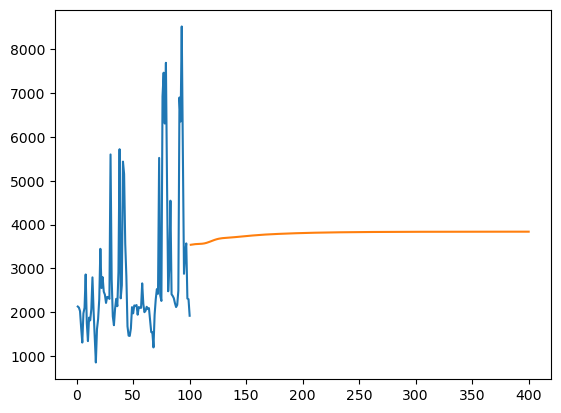

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[2168:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

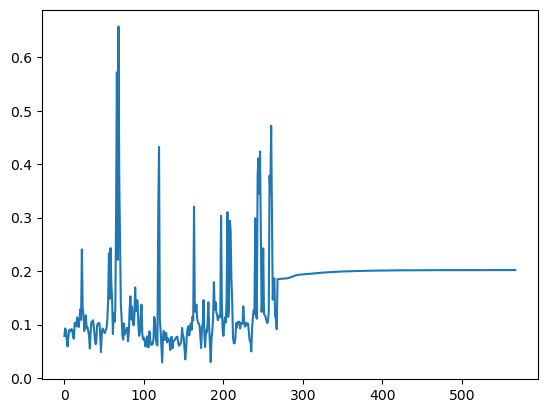

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

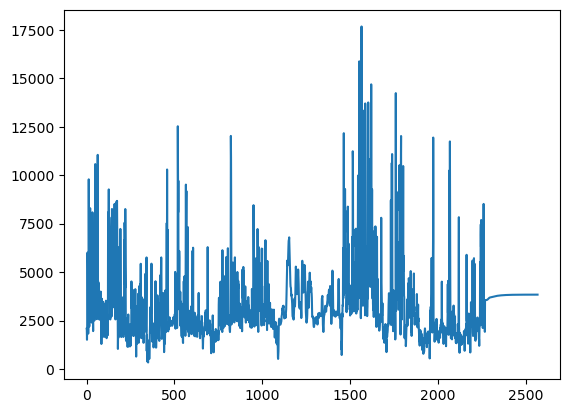

In [ ]:
plt.plot(df3)